<a href="https://colab.research.google.com/github/nttssv/daily_run/blob/master/pairtrade_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

# ADF test for stationary series
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    print(pvalue)
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    y_axis = []
    for i in range(n):
        y_axis.append(keys[i])
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append((keys[i], keys[j],pvalue))
    return score_matrix, pvalue_matrix, pairs , y_axis
  

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2023, 4, 2)

tickers = ['MSFT','IBM']
tickers_r = tickers[::-1]

df = pdr.get_data_yahoo(tickers, start, end)['Adj Close']


# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs,y_axis = find_cointegrated_pairs(df)

#import seaborn
#fig, ax = plt.subplots(figsize=(10,10))
#seaborn.heatmap(pvalues, xticklabels=y_axis, yticklabels=y_axis, cmap='RdYlGn_r' 
#                , mask = (pvalues >= 0.01), annot = True
#                )
#plt.grid()
print(pairs)
print(pvalues)


[*********************100%***********************]  2 of 2 completed
[]
[[1.         0.02081913]
 [1.         1.        ]]


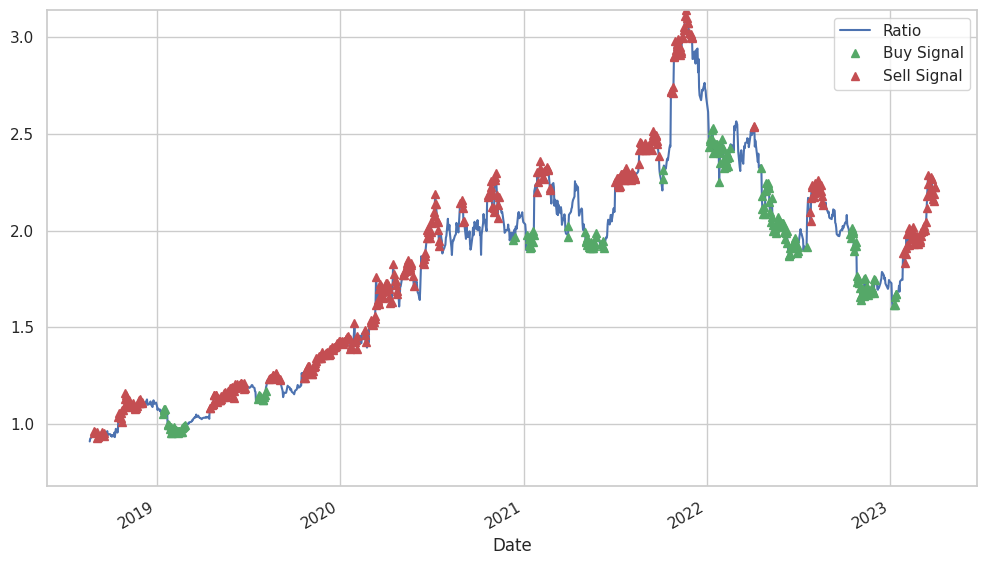

In [10]:
plt.figure(figsize=(12,7))
S1 = df['MSFT']
S2 = df['IBM']

ratios = S1/S2
ratios_mavg5 = ratios.rolling(window=5, center=False).mean()
ratios_mavg60 = ratios.rolling(window=60, center=False).mean()
std_60 = ratios.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

buy = ratios.copy()
sell = ratios.copy()

buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
ratios[160:].plot()
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])

plt.show()

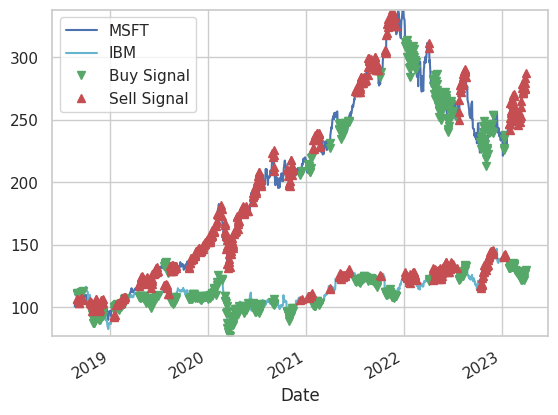

In [11]:
S1[160:].plot(color='b')
S2[160:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[160:].plot(color='g', linestyle='None', marker='v')
sellR[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

#plt.xlim('2022-10-01', '2022-11-08')


plt.legend(['MSFT', 'IBM', 'Buy Signal', 'Sell Signal'])
plt.show()


In [30]:

# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    print('----- money--- ratio -- stock 1 , stock 2')
    day_ex = 0
    equity = []
    
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            day_ex = S1[S1== S1[i]].index[0]
            print('Selling Ratio: %s , %s %s %s %s'%(day_ex,money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            day_ex = S1[S1== S1[i]].index[0]
            print('Selling Ratio: %s , %s %s %s %s'%(day_ex,money, ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            day_ex = S1[S1== S1[i]].index[0]
            print('Selling Ratio: %s , %s %s %s %s'%(day_ex,money, ratios[i], countS1,countS2))
        
        equity.append([day_ex,money])     
    
    return money, equity

In [56]:
money, equity = trade(df['MSFT'].iloc[160:], df['IBM'].iloc[160:], 60, 5)
# 

----- money--- ratio -- stock 1 , stock 2
Selling Ratio: 2018-11-13 00:00:00 , -1.4210854715202004e-14 1.0964699126283706 -1 1.0964699126283706
Selling Ratio: 2018-11-14 00:00:00 , -1.4210854715202004e-14 1.0866759701064048 -2 2.1831458827347756
Selling Ratio: 2018-11-15 00:00:00 , -1.4210854715202004e-14 1.0992495921910561 -3 3.2823954749258317
Selling Ratio: 2018-11-16 00:00:00 , -1.4210854715202004e-14 1.1084123442044735 -4 4.3908078191303055
Selling Ratio: 2018-11-19 00:00:00 , -1.4210854715202004e-14 1.0820623761844481 -5 5.472870195314753
Selling Ratio: 2018-11-20 00:00:00 , -1.4210854715202004e-14 1.0798795782946664 -6 6.55274977360942
Selling Ratio: 2018-11-21 00:00:00 , 0.0 1.0820949456451232 -7 7.634844719254543
Selling Ratio: 2018-11-23 00:00:00 , 1.4210854715202004e-14 1.0944125496107768 -8 8.72925726886532
Selling Ratio: 2018-11-26 00:00:00 , 2.842170943040401e-14 1.108104718665371 -9 9.837361987530691
Selling Ratio: 2018-11-27 00:00:00 , 2.842170943040401e-14 1.1107111126

In [57]:
equity = np.array(equity)

In [58]:
equity[:160]

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [Timestamp('2018-11-13 00:00:00'), -1.4210854715202004e-14],
       [Timestamp('2018-11-14 00:00:00'), -1.42

In [59]:
equity = pd.DataFrame(equity)
equity = equity[(equity.T != 0).any()]

In [63]:
equity.columns = ['Date','Equity']
equity = equity.set_index(['Date'])
#equity['Date'] = pd.to_numeric(pd.to_datetime(equity['Date']))

In [64]:
equity

,Equity
Date,
2018-11-13,-0.0
2018-11-14,-0.0
2018-11-15,-0.0
2018-11-16,-0.0
2018-11-19,-0.0
...,...
2023-03-27,5030.802798
2023-03-28,5030.802798
2023-03-29,5030.802798


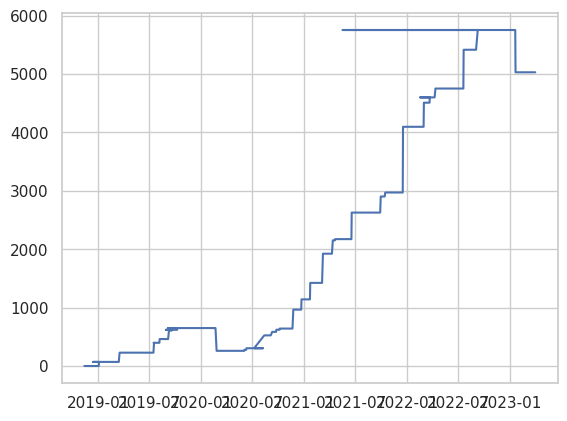

In [66]:
plt.plot(equity.index, equity.Equity)